<a href="https://colab.research.google.com/github/rahiakela/advanced-deep-learning-with-tensorflow-2-and-keras/blob/4-generative-adversarial-networks/4_implementing_deep_least_squares_gan_in_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementing Least-squares GAN in Keras

We will implement a GAN that learns to produce realistic-looking handwritten digits. We will use the Python neural network library Keras with a TensorFlow backend.

Over the course of the training iterations, the Generator learns to turn random noise input into images that look like members of the training data: the MNIST dataset of handwritten digits. 

<img src='https://github.com/rahiakela/img-repo/blob/master/gans-in-action/gan-network.png?raw=1' width='800'/>

Simultaneously, the Discriminator learns to distinguish the fake images produced by the Generator from the genuine ones coming from the training dataset.

In deep learning, both the generator and discriminator can be implemented using
a suitable neural network architecture. If the data or signal is an image, both the generator and discriminator networks will use a CNN. For single-dimensional
sequences such as audio, both networks are usually recurrent (RNN, LSTM, or GRU).

<img src='https://github.com/rahiakela/img-repo/blob/master/dcgan-model.png?raw=1' width='800'/>

DCGAN implements the following design principles:

* Use strides > 1, and a convolution instead of MaxPooling2D or UpSampling2D.
With strides > 1, the CNN learns how to resize the feature maps.

* Avoid using Dense layers. **Use CNN in all layers**. The Dense layer is utilized only as the first layer of the generator to accept the z-vector. The output of the Dense layer is resized and becomes the input of the succeeding CNN
layers.

* Use **Batch Normalization (BN)** to stabilize learning by normalizing the input to each layer to have zero mean and unit variance. There is no BN in the
generator output layer and discriminator input layer. In the implementation
example to be presented here, no batch normalization is used in the
discriminator.

* **Rectified Linear Unit (ReLU)** is used in all layers of the generator except in the output layer, where the tanh activation is utilized. In the implementation example to be presented here, sigmoid is used instead of tanh in the output of the generator since it generally results in more stable training for MNIST digits.

* **Rectified Linear Unit (ReLU)** is used in all layers of the generator except in the output layer, where the tanh activation is utilized. In the implementation example to be presented here, sigmoid is used instead of tanh in the output of the generator since it generally results in more stable training for MNIST digits.

* Use **Leaky ReLU** in all layers of the discriminator. Unlike ReLU, instead
of zeroing out all outputs when the input is less than zero, Leaky ReLU
generates a small gradient equal to alpha x input. In the following example,
alpha = 0.2.

## LSGAN implementation using Keras

LSGAN proposes the least squares loss. It demonstrates why the use of
a sigmoid cross-entropy loss in GANs results in poorly generated data quality:

<img src='https://github.com/rahiakela/img-repo/blob/master/LSGAN.png?raw=1' width='800'/>

Ideally, the fake sample distribution should be as close as possible to the true
samples' distribution. However, for GANs, once the fake samples are already on
the correct side of the decision boundary, the gradients vanish.

This prevents the generator from having enough motivation to improve the
quality of the generated fake data. Fake samples far from the decision boundary
will no longer attempt to move closer to the true samples' distribution.

Using the least squares loss function, the gradients do not vanish as long as the fake sample distribution is far from the real samples' distribution. The generator will strive to improve its estimate of real density distribution even if the fake samples are already on the correct side of the decision boundary.

Both the discriminator and adversarial loss functions are replaced by mse. All the network parameters are the same as in DCGAN. The network model of LSGAN
in tf.keras is similar to WGAN except that there is linear or no output
activation. The training process is similar to that seen in DCGAN and is provided by the utility function.




## Setup

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Activation, Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K

from tensorflow.keras.datasets import  mnist

import numpy as np
import pandas as pd
import math
import os

import matplotlib.pyplot as plt

##  Implementing the Generator

In [0]:
def build_generator(inputs, image_size, activation='sigmoid', labels=None, codes=None):

    image_resize = image_size // 4
    # network parameters
    kernel_size = 5
    layer_filters = [128, 64, 32, 1]

    if labels is not None:
        if codes is None:
            # ACGAN labels
            # concatenate z noise vector and one-hot labels
            inputs = [inputs, labels]
        else:
            # infoGAN codes
            # concatenate z noise vector, 
            # one-hot labels and codes 1 & 2
            inputs = [inputs, labels] + codes
        x = concatenate(inputs, axis=1)
    elif codes is not None:
        # generator 0 of StackedGAN
        inputs = [inputs, codes]
        x = concatenate(inputs, axis=1)
    else:
        # default input is just 100-dim noise (z-code)
        x = inputs

    x = Dense(image_resize * image_resize * layer_filters[0])(x)
    x = Reshape((image_resize, image_resize, layer_filters[0]))(x)

    for filters in layer_filters:
        # first two convolution layers use strides = 2
        # the last two use strides = 1
        if filters > layer_filters[-2]:
            strides = 2
        else:
            strides = 1
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2DTranspose(filters=filters,
                            kernel_size=kernel_size,
                            strides=strides,
                            padding='same')(x)

    if activation is not None:
        x = Activation(activation)(x)

    # generator output is the synthesized image x
    return Model(inputs, x, name='generator')

## Implementing the Discriminator

In [0]:
def build_discriminator(inputs, activation='sigmoid', num_labels=None, num_codes=None):
    
    kernel_size = 5
    layer_filters = [32, 64, 128, 256]

    x = inputs
    for filters in layer_filters:
        # first 3 convolution layers use strides = 2
        # last one uses strides = 1
        if filters == layer_filters[-1]:
            strides = 1
        else:
            strides = 2
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   strides=strides,
                   padding='same')(x)

    x = Flatten()(x)
    # default output is probability that the image is real
    outputs = Dense(1)(x)
    if activation is not None:
        print(activation)
        outputs = Activation(activation)(outputs)

    if num_labels:
        # ACGAN and InfoGAN have 2nd output
        # 2nd output is 10-dim one-hot vector of label
        layer = Dense(layer_filters[-2])(x)
        labels = Dense(num_labels)(layer)
        labels = Activation('softmax', name='label')(labels)
        if num_codes is None:
            outputs = [outputs, labels]
        else:
            # InfoGAN have 3rd and 4th outputs
            # 3rd output is 1-dim continous Q of 1st c given x
            code1 = Dense(1)(layer)
            code1 = Activation('sigmoid', name='code1')(code1)

            # 4th output is 1-dim continuous Q of 2nd c given x
            code2 = Dense(1)(layer)
            code2 = Activation('sigmoid', name='code2')(code2)

            outputs = [outputs, labels, code1, code2]
    elif num_codes is not None:
        # StackedGAN Q0 output
        # z0_recon is reconstruction of z0 normal distribution
        z0_recon =  Dense(num_codes)(x)
        z0_recon = Activation('tanh', name='z0')(z0_recon)
        outputs = [outputs, z0_recon]

    return Model(inputs, outputs, name='discriminator')

## Building and Training GAN model

Due to custom training, the usual fit() function is not going
to be used. Instead, train_on_batch() is called up to run a single gradient update for the given batch of data. The generator is then trained via an adversarial network.

The training first randomly picks a batch of real images from the dataset. This is labeled as real (1.0). Then, a batch of fake images will be generated by the generator. This is labeled as fake (0.0). The two batches are concatenated and are used to train the discriminator.

After this is complete, a new batch of fake images will be generated by the generator and labeled as real (1.0). This batch will be used to train the adversarial network. The two networks are trained alternately for about 40,000 steps. At regular intervals, the generated MNIST digits based on a certain noise vector are saved on the filesystem. At the last training step, the network has converged.

In [0]:
def train(models, x_train, params):
  # the GAN component models
  generator, discriminator, adversarial = models

  # network parameters
  (batch_size, latent_size, n_critic, clip_value, train_steps, model_name) = params

  # the generator image is saved every 500 steps
  save_interval = 500

  # noise vector to see how the generator output evolves during training
  noise_input = np.random.uniform(-1.0, 1.0, size=[16, latent_size])

  # number of elements in train dataset
  train_size = x_train.shape[0]
  # labels for real data
  real_labels = np.ones((batch_size, 1))

  for i in range(train_steps):
    # train discriminator n_critic times
    loss = 0
    acc = 0
    for _ in range(n_critic):
      ### train the discriminator for 1 batch ###
      '''
      1 batch of real (label=1.0) and fake images (label=0.0) and randomly pick real images from dataset
      '''
      rand_indexes = np.random.randint(0, train_size, size=batch_size)
      real_images = x_train[rand_indexes]

      ### generate fake images from noise using generator ###
      # generate noise using uniform distribution
      noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_size])

      # generate fake images
      fake_images = generator.predict(noise)

      # train the discriminator network
      '''
      real data label=1, fake data label=-1 instead of 1 combined batch of real and fake images,
      train with 1 batch of real data first, then 1 batch of fake images.
      this tweak prevents the gradient from vanishing due to opposite
      signs of real and fake data labels (i.e. +1 and -1) and small magnitude of weights due to clipping.
      '''
      real_loss, real_acc = discriminator.train_on_batch(real_images, real_labels)
      fake_loss, fake_acc = discriminator.train_on_batch(fake_images, -real_labels)
      # accumulate average loss and accuracy
      loss += 0.5 * (real_loss + fake_loss)
      acc += 0.5 * (real_acc + fake_acc)

      # clip discriminator weights to satisfy Lipschitz constraint
      for layer in discriminator.layers:
        weights = layer.get_weights()
        weights = [np.clip(weight, -clip_value, clip_value) for weight in weights]
        layer.set_weights(weights)

    # average loss and accuracy per n_critic training iterations
    loss /= n_critic
    acc /= n_critic
    log = "%d: [discriminator loss: %f, acc: %f]" % (i, loss, acc)

    ### train the adversarial network for 1 batch ###
    '''
    1 batch of fake images with label=1.0 since the discriminator weights are frozen in adversarial network only the generator is trained
    '''
    #  generate noise using uniform distribution
    noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_size])

    ### train the adversarial network ###
    ''' 
    Note that unlike in discriminator training, we do not save the fake images in a variable the fake images go 
    to the discriminator input of the adversarial for classification
    '''
    # log the loss and accuracy
    loss, acc = adversarial.train_on_batch(noise, real_labels)
    log = "%s [adversarial loss: %f, accuracy: %f]" % (log, loss, acc)
    print(log)

    if (i + 1) % save_interval == 0:
      # plot generator images on a periodic basis
      plot_images(generator, noise_input, show=True, step=(i + 1), model_name=model_name)

  '''
  save the model after training the generator, the trained generator can be reloaded for future MNIST digit generation
  '''
  generator.save(model_name + '.h5')

def plot_images(generator, noise_input, show=False, step=0, model_name='gan'):
  os.makedirs(model_name, exist_ok=True)
  filename = os.path.join(model_name, "%05d.png" % step)
  images = generator.predict(noise_input)
  plt.figure(figsize=(2.2, 2.2))
  num_images = images.shape[0]
  image_size = images.shape[1]
  rows = int(math.sqrt(noise_input.shape[0]))
  for i in range(num_images):
      plt.subplot(rows, rows, i + 1)
      image = np.reshape(images[i], [image_size, image_size])
      plt.imshow(image, cmap='gray')
      plt.axis('off')
  plt.savefig(filename)
  if show:
      plt.show()
  else:
      plt.close('all')

def wasserstein_loss(y_label, y_pred):
    return -K.mean(y_label * y_pred)

Now let's build GAN models. Firstly, the discriminator model is built and, following on from that, the generator model is instantiated. The adversarial model is just the generator and the discriminator put together. Across many GANs, the batch size of 64 appears to be the most common.

In [0]:
def build_and_train_models():
  # load MNIST dataset
  (x_train, _), (_, _) = mnist.load_data()

  # reshape data for CNN as (28, 28, 1) and normalize
  image_size = x_train.shape[1]
  x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
  x_train = x_train.astype('float32') / 255

  model_name = 'lsgan_mnist'

  # network parameters, the latent or z vector is 100-dim
  latent_size = 100
  # hyper parameters from WGAN paper
  n_critic = 5
  clip_value = 0.01
  batch_size = 64
  train_steps = 40000
  lr = 2e-4
  decay = 6e-8
  input_shape = (image_size, image_size, 1)

  ### build discriminator model ###
  inputs = Input(shape=input_shape, name='discriminator_input')
  # WGAN uses linear activation in paper
  discriminator = build_discriminator(inputs, activation=None)
  # original paper uses Adam, but discriminator converges easily with RMSprop
  optimizer = RMSprop(learning_rate=lr)
  # LSGAN uses MSE loss [2]
  discriminator.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
  discriminator.summary()

  ### build generator model ###
  input_shape = (latent_size, )
  inputs = Input(shape=input_shape, name='z_input')
  generator = build_generator(inputs, image_size)
  generator.summary()

  ### build adversarial model ###
  #  freeze the weights of discriminator during adversarial training
  discriminator.trainable = False

  # adversarial = generator + discriminator
  adversarial = Model(inputs, discriminator(generator(inputs)), name=model_name)
  # LSGAN uses MSE loss
  adversarial.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
  adversarial.summary()

  # train discriminator and adversarial networks
  models = (generator, discriminator, adversarial)
  params = (batch_size, latent_size, n_critic, clip_value, train_steps, model_name)
  train(models, x_train, params)

The DCGAN models are straightforward. What makes them difficult to build is the fact that small changes in the network design can easily break the training convergence. For example, if batch normalization is used in the discriminator, or if strides = 2 in the generator is transferred to the latter CNN layers, DCGAN will fail to converge.

In [0]:
build_and_train_models()

## Testing the model

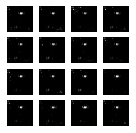

In [7]:
def test_generator(generator):
  noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])

  plot_images(generator, noise_input=noise_input, show=True, model_name="test_outputs")

# load saved model
generator = load_model('lsgan_mnist.h5')
test_generator(generator)

## Conclusion

With the use of MSE or L2, we addressed the twin problems of training the stability and perceptive quality of the GANs.